# 0. Import thư viện

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

# 1. Data preprocessing

In [ ]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0


In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="0zQUDwd0LCNQbBNvcADD")
project = rf.workspace("test-rgyee").project("yolo-ocr")
version = project.version(2)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.



Extracting Dataset Version Zip to yolo-ocr-2 in yolov8:: 100%|██████████| 4476/4476 [00:01<00:00, 2802.92it/s]


In [ ]:
image_train_paths = "/content/yolo-ocr-2/train/images/"
label_train_paths = "/content/yolo-ocr-2/train/labels/"
image_test_paths = "/content/yolo-ocr-2/test/images/"
label_test_paths = "/content/yolo-ocr-2/test/labels/"

In [ ]:
list_image_train = sorted(os.listdir(image_train_paths))
list_label_train = sorted(os.listdir(label_train_paths))
list_image_test = sorted(os.listdir(image_test_paths))
list_label_test = sorted(os.listdir(label_test_paths))

In [ ]:
print("Số lượng ảnh train: ", len(list_image_train))
print("Số lượng ảnh test: ", len(list_image_test))

Số lượng ảnh train:  1565
Số lượng ảnh test:  222


**Ảnh mẫu**

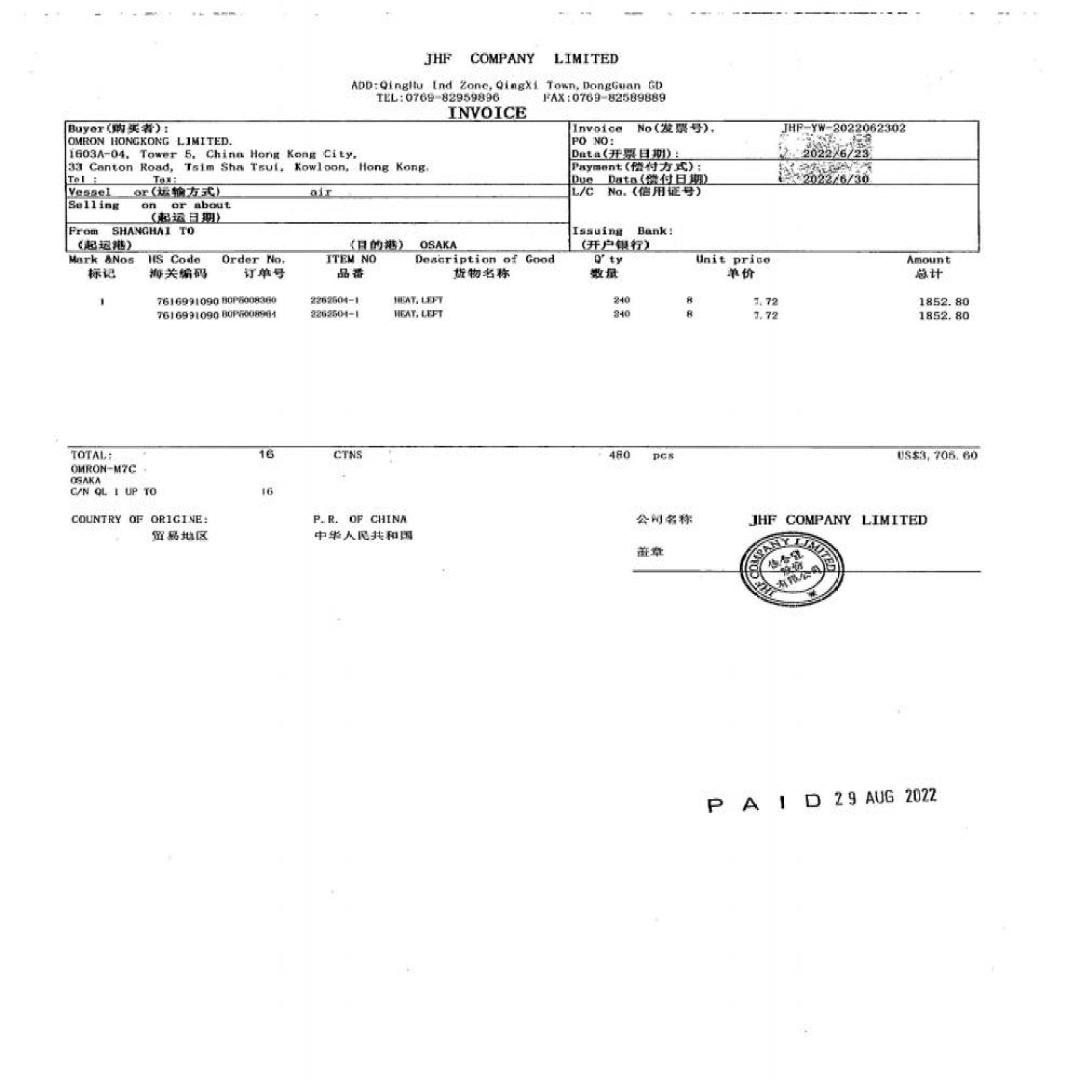

In [ ]:
random_index = np.random.randint(0, len(list_image_train))
image_train = list_image_train[random_index]
label_train = list_label_train[random_index]
img = Image.open(os.path.join(image_train_paths, image_train))
img

In [ ]:
path = os.path.join(label_train_paths, label_train)
with open(path, 'r') as f:
  lines = f.readlines()

In [ ]:
def denormalize_labels(labels, image_width, image_height):
    denormalized_labels = []
    for label in labels:
        cls, x_center, y_center, width, height = map(float, label.split())
        x_center = x_center * image_width
        y_center = y_center * image_height
        width = width * image_width
        height = height * image_height

        x_min = int(x_center - (width / 2))
        y_min = int(y_center - (height / 2))
        x_max = int(x_center + (width / 2))
        y_max = int(y_center + (height / 2))

        denormalized_labels.append([int(cls), x_min, y_min, x_max, y_max])

    return denormalized_labels

In [ ]:
img = cv2.imread(os.path.join(image_train_paths, image_train))

In [ ]:
label = denormalize_labels(lines, img.shape[1], img.shape[0])

In [ ]:
label

[[6, 567, 118, 917, 134],
 [5, 571, 146, 881, 158],
 [1, 66, 134, 242, 148],
 [0, 66, 148, 433, 176],
 [8, 52, 253, 997, 466],
 [9, 879, 441, 992, 462],
 [4, 888, 445, 920, 461],
 [3, 725, 529, 869, 607]]

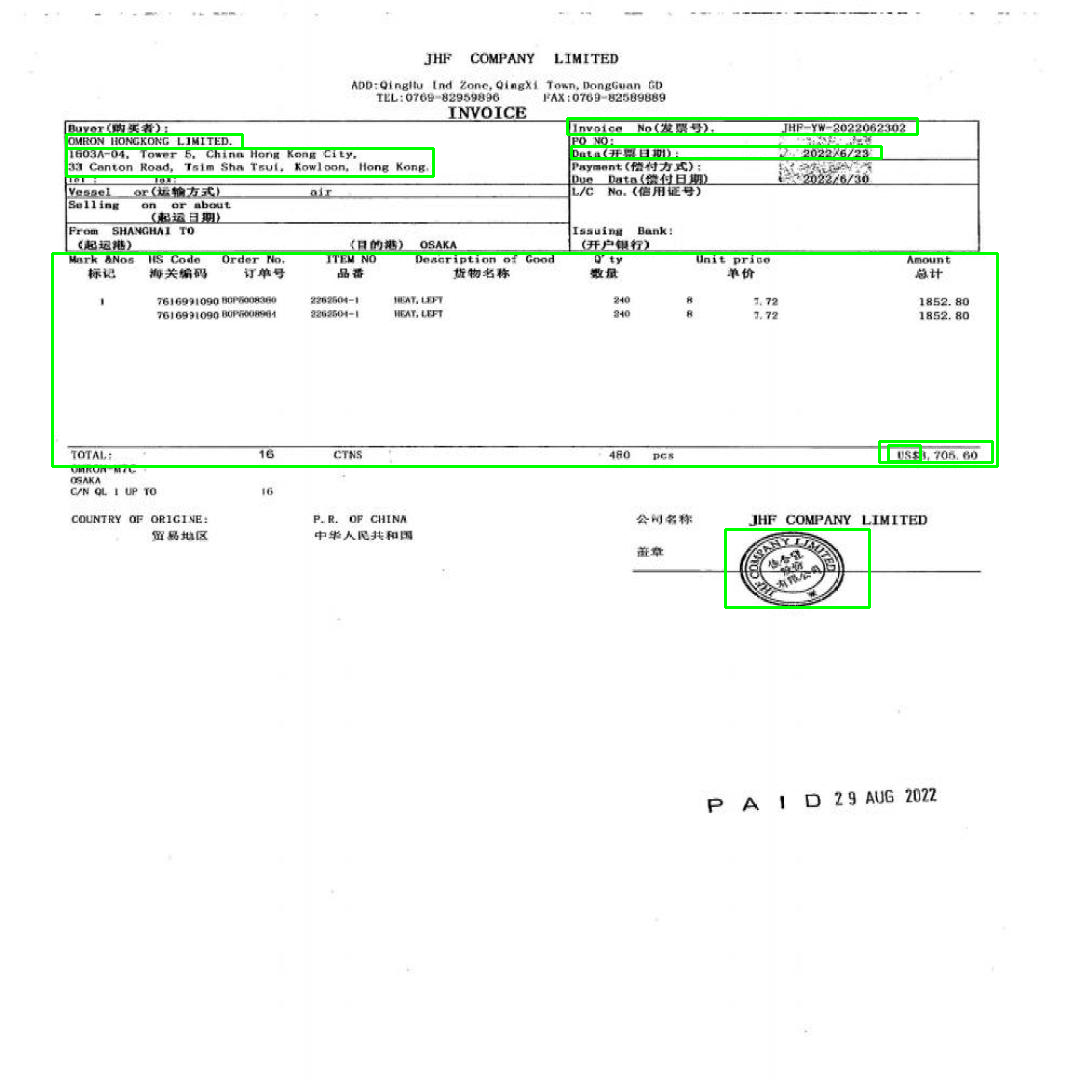

In [ ]:
from google.colab.patches import cv2_imshow
for item in label:
  cv2.rectangle(img, (item[1], item[2]), (item[3], item[4]), (0, 255, 0), 2)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 2. Text Detection

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 6.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
from ultralytics import YOLO

In [ ]:
# Trước khi train thì nên dùng shutil để đưa chuyển thành thư mục này(lý do thì tôi chưa tìm ra)
import shutil

shutil.move('/content/yolo-ocr-2/train',
            '/content/yolo-ocr-2/yolo-ocr-2/train'
            )

shutil.move('/content/yolo-ocr-2/test',
            '/content/yolo-ocr-2/yolo-ocr-2/test'
            )

shutil.move('/content/yolo-ocr-2/valid',
            '/content/yolo-ocr-2/yolo-ocr-2/valid'
            )

'/content/yolo-ocr-2/yolo-ocr-2/valid'

In [ ]:
# Train
!yolo task=detect mode=train model='/content/drive/MyDrive/OCR_Bill/best.pt' data={dataset.location}/data.yaml epochs=30 imgsz=640

Ultralytics YOLOv8.2.56 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/OCR_Bill/best.pt, data=/content/yolo-ocr-2/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_la

In [ ]:
model = YOLO('/content/runs/detect/train/weights/best.pt')

In [ ]:
result = model.predict(img)


0: 640x640 1 OMRON_address, 1 OMRON_name, 1 company_chop, 1 table, 73.5ms
Speed: 4.1ms preprocess, 73.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
result

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'OMRON_address', 1: 'OMRON_name', 2: 'bill_to', 3: 'company_chop', 4: 'currency', 5: 'date', 6: 'invoice_no', 7: 'ship_to', 8: 'table', 9: 'total_amount'}
 obb: None
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 

In [ ]:
bbox = result[0].boxes.data
bbox #(x_min, y_min, x_max, y_max, confidence, class)

tensor([[7.3466e+02, 5.3191e+02, 8.5175e+02, 6.1021e+02, 8.5271e-01, 3.0000e+00],
        [5.6263e+01, 2.5103e+02, 1.0052e+03, 4.6592e+02, 7.9653e-01, 8.0000e+00],
        [6.3146e+01, 1.3476e+02, 2.4393e+02, 1.4677e+02, 7.1274e-01, 1.0000e+00],
        [6.5690e+01, 1.4867e+02, 4.3892e+02, 1.7098e+02, 7.0058e-01, 0.0000e+00]], device='cuda:0')

In [ ]:
img2 = cv2.imread(os.path.join(image_train_paths, image_train))
# for item in bbox:
#   x_min, y_min, x_max, y_max, conf, cls = item
#   x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
#   cv2.rectangle(img2, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
cv2_imshow(img2)
cv2.waitKey(0)
cv2.destroyAllWindows()

AttributeError: 'NoneType' object has no attribute 'clip'

# 3. Text Recognition

In [ ]:
!pip install --quiet vietocr

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 28.9 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

In [ ]:
config = Cfg.load_config_from_name('vgg_transformer')

In [ ]:
# config['weights'] = './weights/transformerocr.pth'
config['cnn']['pretrained']=False
config['device'] = 'cuda:0'

In [ ]:
detector = Predictor(config)

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
18533it [00:03, 5105.62it/s]


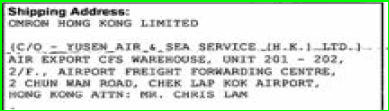

In [ ]:
x_min, y_min, x_max, y_max, conf, cls = bbox[1]
x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
bbox_1 = img2[y_min:y_max, x_min:x_max]
cv2_imshow(bbox_1)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
bbox_1_pil = Image.fromarray(bbox_1)
detector.predict(bbox_1_pil)

'CONTRACT'

## 3.x Train model

In [ ]:
# from vietocr.model.trainer import Trainer

In [ ]:
# config = Cfg.load_config_from_name('vgg_transformer')

In [ ]:
# dataset_params = {
#     'name':'hw',
#     'data_root':'./data_line/',
#     'train_annotation':'train_line_annotation.txt',
#     'valid_annotation':'test_line_annotation.txt'
# }

# params = {
#          'print_every':200,
#          'valid_every':15*200,
#           'iters':20000,
#           'checkpoint':'./checkpoint/transformerocr_checkpoint.pth',
#           'export':'./weights/transformerocr.pth',
#           'metrics': 10000
#          }

# config['trainer'].update(params)
# config['dataset'].update(dataset_params)
# config['device'] = 'cuda:0'

In [ ]:
# trainer = Trainer(config, pretrained=True)

In [ ]:
# trainer.config.save('config.yml') # Lưu lại cấu hình của model

In [ ]:
# trainer.visualize_dataset() # Kiểm tra xem dữ liệu dùng để train hợp lí chưa

In [ ]:
# trainer.train()

# 4. Demo with gradio

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

In [ ]:
model = YOLO('/content/drive/MyDrive/OCR_Bill/best.pt')

In [ ]:
def OCR_bill(img_input):
  result = model.predict(img_input)
  list_bbox = result[0].boxes.data
  for bbox in list_bbox:
    x_min, y_min, x_max, y_max, conf, cls = bbox[1]
    if cls == 6:
      x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
      bbox_1 = img2[y_min:y_max, x_min:x_max]
    break
  invoice_number_bbox = img[y_min:y_max, x_min:x_max]
  temp1 = Image.fromarray(invoice_number_bbox)
  invoice_number = detector.predict(temp1)
  return invoice_number

In [ ]:
# Tạo giao diện Gradio
with gr.Blocks() as demo:
    gr.Markdown("## OCR App")
    img_input = gr.Image(type="pil", label="Đưa hóa đơn lên: ")
    btn = gr.Button("Run")
    result_output = gr.Textbox(label="Kết quả", lines=10)
    btn.click(fn=OCR_bill, inputs=img_input, outputs=result_output)

# Chạy ứng dụng
demo.launch()